In [4]:
!which python

/opt/homebrew/Caskroom/miniconda/base/bin/python


In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
from data import *
import pandas as pd
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import seaborn as sns
from matplotlib.lines import Line2D


In [9]:
df = df_transactions()
df['date'] = pd.to_datetime(df['date'])
df['customer_id'] = df['customer_id'].astype(int)
df['itemcat'] = df['item'].apply(item_cat)
df = pd.concat([df,
    pd.get_dummies(df['item']).astype(float),
    pd.get_dummies(df['itemcat']).astype(float),
    pd.get_dummies(df['payment_method']).astype(float),
    pd.get_dummies(df['location']).astype(float),
    pd.get_dummies(df['category']).astype(float),
], axis=1)
games = df_games()
home_wins = games[(games['HOME']) & (games['W/L'] == 'W')]
home_losses = games[(games['HOME']) & (games['W/L'] == 'L')]
df_home_wins = df[df['transaction_datetime'].dt.date.isin(home_wins['DATE'].dt.date.unique())]
df_home_losses = df[df['transaction_datetime'].dt.date.isin(home_losses['DATE'].dt.date.unique())]
df['win'] = np.nan
df.loc[df['transaction_datetime'].dt.date.isin(home_wins['DATE'].dt.date.unique()), 'win'] = 1
df.loc[df['transaction_datetime'].dt.date.isin(home_losses['DATE'].dt.date.unique()), 'win'] = 0

games['OPP'] = games['MATCHUP'].str.split().str[-1]
games['W/L'] = games['W/L'].map({'W': 1.0, 'L': 0.0})
games['HOME'] = games['HOME'].map({True: 1, False: 0})
conference = {'BKN': 1, 'OKC': 0,'IND': 1,'NYK': 1,'GSW': 0,'SAC': 0,'POR': 0,
              'DET': 1,'DEN': 0,'PHI': 1,'MIA': 1,'LAL': 0,'TOR': 1,'ATL': 1,
              'ORL': 1,'BOS': 1,'HOU': 0,'UTA': 0,'NOP': 0,'CHI': 1,'DAL': 0,
              'MIL': 1,'WAS': 1,'SAS': 0,'LAC': 0,'MEM': 0,'MIN': 0,'PHX': 0,'CHA': 1,}
games['OPP_CONF'] = games['OPP'].map(conference)
df = df.merge(games, left_on='date', right_on='DATE', how='left', validate='m:1')

gamestart = df.groupby(['date'])['transaction_datetime'].min().reset_index()
gamestart.rename(columns={'transaction_datetime':'gamestart'}, inplace=True)
gameend = df.groupby(['date'])['transaction_datetime'].max().reset_index()
gameend.rename(columns={'transaction_datetime':'gameend'}, inplace=True)
gametimes = gamestart.merge(gameend, on=['date'])
df = df.merge(gametimes, on='date', how='left', validate='m:1')
df['seconds_since_gamestart'] = (df['transaction_datetime'] - df['gamestart']).dt.seconds
df['days_since_seasonstart'] = (df['date'] - df['date'].min()).apply(lambda x: x.days)
df = df.drop(columns=['item', 'itemcat', 'payment_method', 'location', 'category'])

In [15]:
df.columns[~df.dtypes.isin(['int64', 'int32', 'float64', 'float32'])]

Index(['transaction_id', 'customer_id', 'quantity', 'transaction_datetime',
       'date', 'hour', 'MATCHUP', 'DATE', 'OPP', 'gamestart', 'gameend',
       'seconds_since_gamestart', 'days_since_seasonstart'],
      dtype='object')

In [21]:
corr = df.drop(columns=df.columns[~df.dtypes.isin(['int64', 'int32', 'float64', 'float32'])]).corr()


In [45]:
corr_matrix = df.drop(columns=df.columns[~df.dtypes.isin(['int64', 'int32', 'float64', 'float32'])]).corr()
plt.figure(figsize=(100,100))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', square=True)
plt.title('Correlation Matrix')
plt.show()

In [8]:
df = df.drop(columns=['transaction_id', 'price', 'subtotal', 'tax', 'transaction_datetime', 'date',
                 'hour', 'MATCHUP', 'W/L', 'MIN', 'PTS', 'FGM', 'FGA', 'FG%', '3PM', '3PA', '3P%', 'HOME',
                 'FTM', 'FTA', 'FT%', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'OPP', 'DATE', 'gamestart', 'gameend'])

# K-Means

In [6]:
groupby = df.groupby('customer_id')
ret = pd.DataFrame()
for col in df.columns:
    if col == 'customer_id': continue
    ret[f'{col}_sum'] = groupby[col].sum()
    ret[f'{col}_mean'] = groupby[col].mean()
ret = ret.reset_index()

/var/folders/bl/cwsqyvm13d90g4_9qyffmckh0000gn/T/ipykernel_6059/2924447833.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ret[f'{col}_sum'] = groupby[col].sum()
/var/folders/bl/cwsqyvm13d90g4_9qyffmckh0000gn/T/ipykernel_6059/2924447833.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ret[f'{col}_mean'] = groupby[col].mean()
/var/folders/bl/cwsqyvm13d90g4_9qyffmckh0000gn/T/ipykernel_6059/2924447833.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

In [7]:
scaler = StandardScaler()
ret_encoded = pd.DataFrame(scaler.fit_transform(ret.drop(columns='customer_id')), columns=ret.drop(columns='customer_id').columns)

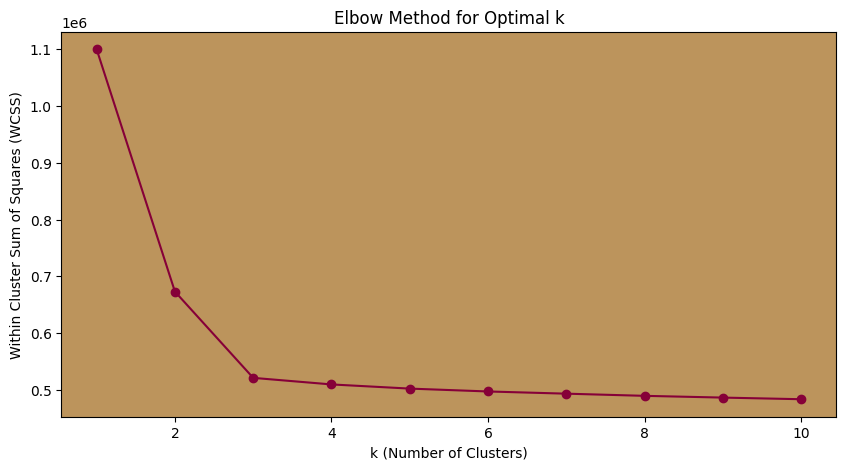

In [8]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
    kmeans.fit(ret_encoded)
    wcss.append(kmeans.inertia_)

# Plot the Elbow Graph
plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), wcss, marker='o', color=C[0])

plt.title('Elbow Method for Optimal k')
plt.xlabel('k (Number of Clusters)')
plt.ylabel('Within Cluster Sum of Squares (WCSS)')
plt.show()

In [9]:
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
ret_encoded['cluster'] = kmeans.fit_predict(ret_encoded)
ret_encoded['cluster'] = ret_encoded['cluster'].map({0:0, 1:2, 2:1})
ret['cluster'] = ret_encoded['cluster']

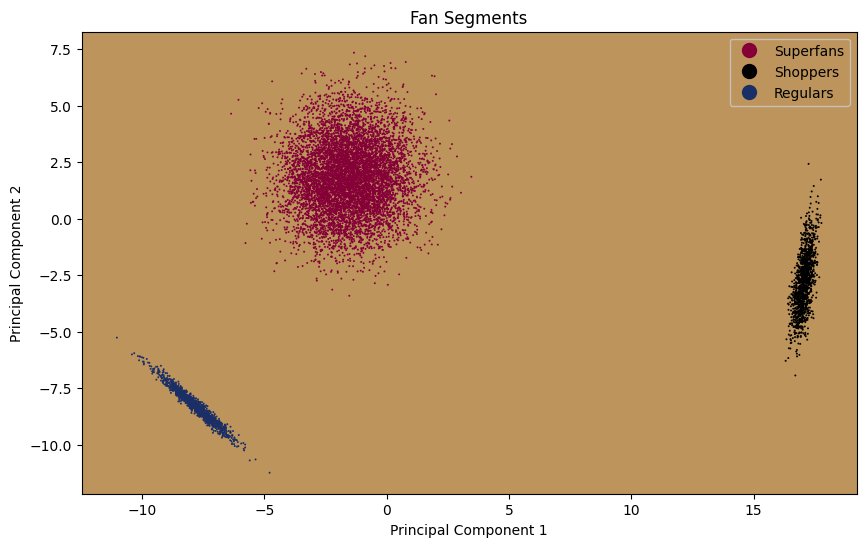

In [10]:
pca = PCA(n_components=2)
principal_components = pca.fit_transform(ret_encoded.drop('cluster', axis=1))
pc_df = pd.DataFrame(data=principal_components, columns=['Principal Component 1', 'Principal Component 2'])
pc_df['cluster'] = ret_encoded['cluster']

plt.figure(figsize=(10, 6))
sns.scatterplot(data=pc_df, x='Principal Component 1', y='Principal Component 2', hue='cluster', palette=C[:3], s=2, alpha=1, edgecolor='none')
plt.title('Fan Segments')
custom_handles = [Line2D([], [], marker='o', markersize=10, linestyle='None', color=C[i], label=L[i]) for i in range(3)]

# Apply new legend with custom handles
plt.legend(handles=custom_handles)
plt.show()

In [11]:
cluster0 = ret[ret['cluster'] == 0]
cluster1 = ret[ret['cluster'] == 1]
cluster2 = ret[ret['cluster'] == 2]

In [12]:
cols_to_plot = [
    'total_amount_sum',
    'total_amount_mean',
    'quantity_sum',
    'quantity_mean',
    'Center Court_mean',
    'Club Level_mean',
    'In-Arena Stand_mean',
    'Loudville_mean',
    'Lower Level_mean',
    'Online_mean',
    'fnb_mean',
    'retail_mean',
]

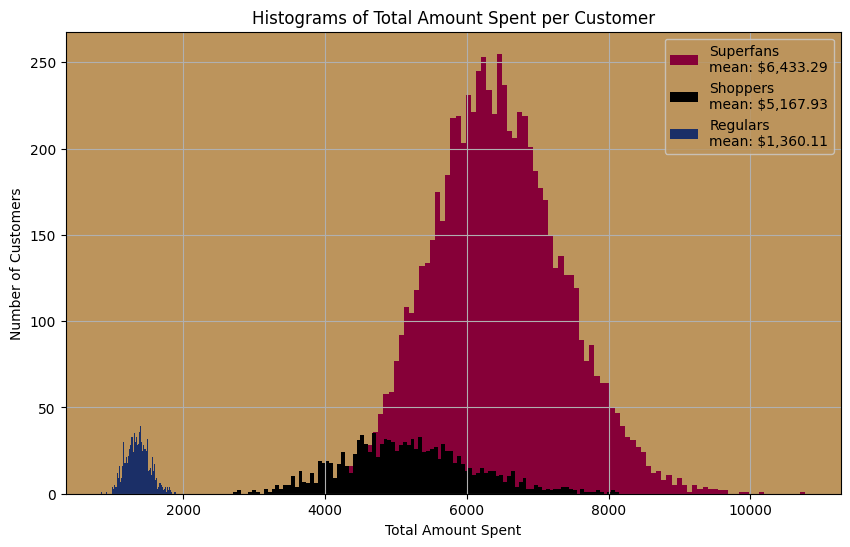

In [13]:
fig, ax = plt.subplots(figsize=(10, 6))
cluster0['total_amount_sum'].hist(bins=100, ax=ax, color=C[0], alpha=1, label=f"{L[0]}\nmean: ${cluster0['total_amount_sum'].mean():,.2f}")
cluster1['total_amount_sum'].hist(bins=100, ax=ax, color=C[1], alpha=1, label=f"{L[1]}\nmean: ${cluster1['total_amount_sum'].mean():,.2f}")
cluster2['total_amount_sum'].hist(bins=100, ax=ax, color=C[2], alpha=1, label=f"{L[2]}\nmean: ${cluster2['total_amount_sum'].mean():,.2f}")
ax.legend()
plt.title('Histograms of Total Amount Spent per Customer')
plt.xlabel('Total Amount Spent')
plt.ylabel('Number of Customers')
plt.show()


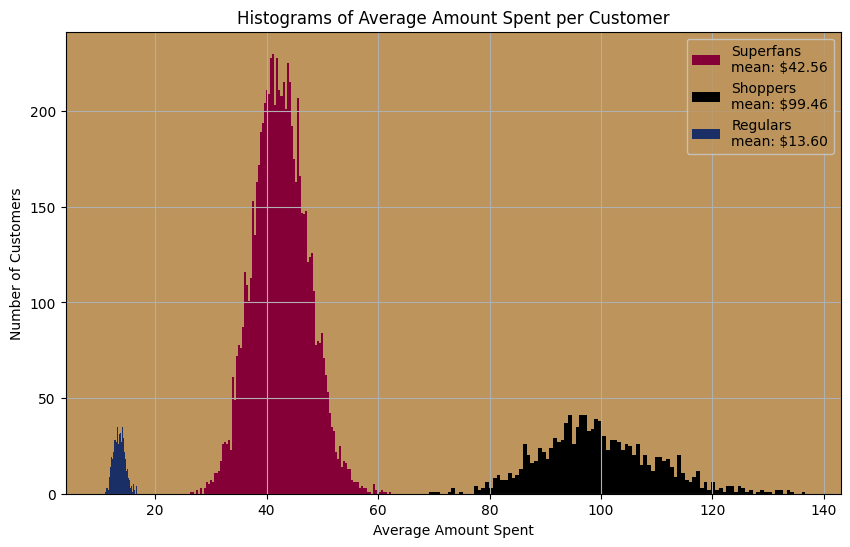

In [14]:
fig, ax = plt.subplots(figsize=(10, 6))
cluster0['total_amount_mean'].hist(bins=100, ax=ax, color=C[0], alpha=1, label=f"{L[0]}\nmean: ${cluster0['total_amount_mean'].mean():,.2f}")
cluster1['total_amount_mean'].hist(bins=100, ax=ax, color=C[1], alpha=1, label=f"{L[1]}\nmean: ${cluster1['total_amount_mean'].mean():,.2f}")
cluster2['total_amount_mean'].hist(bins=100, ax=ax, color=C[2], alpha=1, label=f"{L[2]}\nmean: ${cluster2['total_amount_mean'].mean():,.2f}")
ax.legend()
plt.title('Histograms of Average Amount Spent per Customer')
plt.xlabel('Average Amount Spent')
plt.ylabel('Number of Customers')
plt.show()


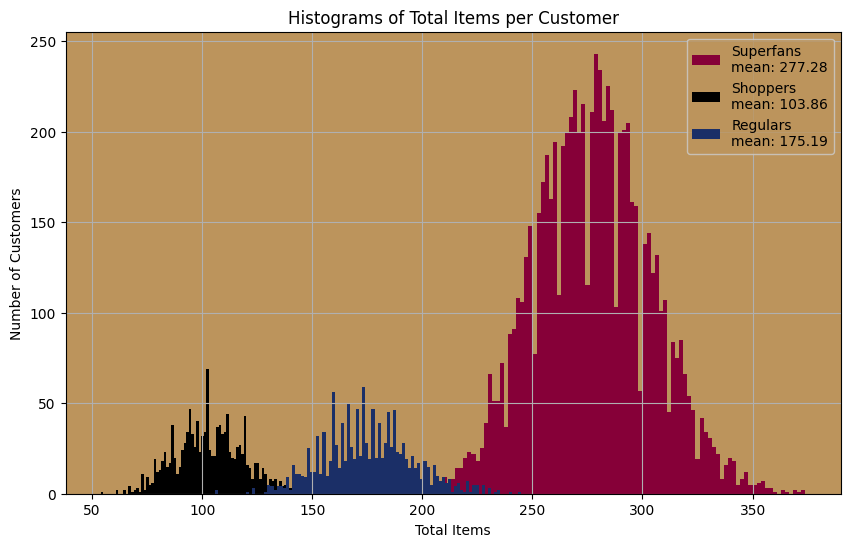

In [15]:
fig, ax = plt.subplots(figsize=(10, 6))
cluster0['quantity_sum'].hist(bins=100, ax=ax, color=C[0], alpha=1, label=f"{L[0]}\nmean: {cluster0['quantity_sum'].mean():,.2f}")
cluster1['quantity_sum'].hist(bins=100, ax=ax, color=C[1], alpha=1, label=f"{L[1]}\nmean: {cluster1['quantity_sum'].mean():,.2f}")
cluster2['quantity_sum'].hist(bins=100, ax=ax, color=C[2], alpha=1, label=f"{L[2]}\nmean: {cluster2['quantity_sum'].mean():,.2f}")
ax.legend()
plt.title('Histograms of Total Items per Customer')
plt.xlabel('Total Items')
plt.ylabel('Number of Customers')
plt.show()


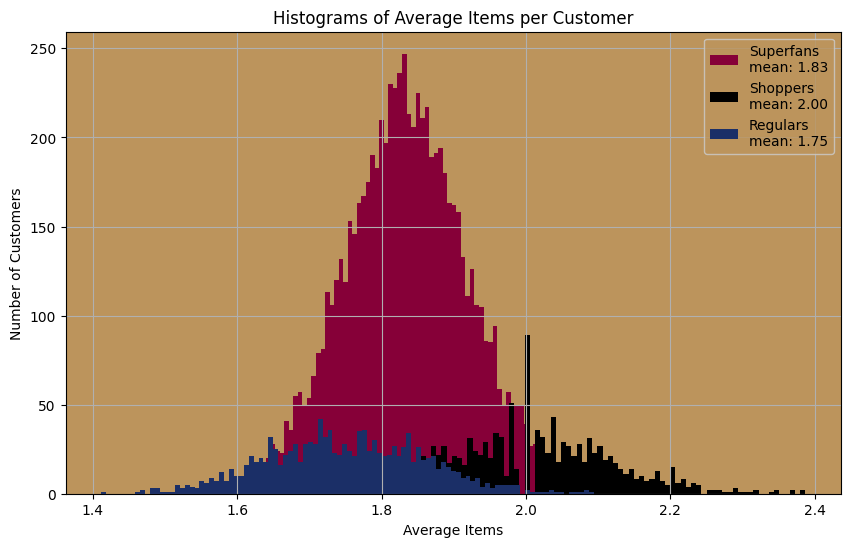

In [16]:
fig, ax = plt.subplots(figsize=(10, 6))
cluster0['quantity_mean'].hist(bins=100, ax=ax, color=C[0], alpha=1, label=f"{L[0]}\nmean: {cluster0['quantity_mean'].mean():,.2f}")
cluster1['quantity_mean'].hist(bins=100, ax=ax, color=C[1], alpha=1, label=f"{L[1]}\nmean: {cluster1['quantity_mean'].mean():,.2f}")
cluster2['quantity_mean'].hist(bins=100, ax=ax, color=C[2], alpha=1, label=f"{L[2]}\nmean: {cluster2['quantity_mean'].mean():,.2f}")
ax.legend()
plt.title('Histograms of Average Items per Customer')
plt.xlabel('Average Items')
plt.ylabel('Number of Customers')
plt.show()


# Victory Boosters

In [ ]:
df = df.merge(ret[['customer_id', 'cluster']].astype({'customer_id': str}), on='customer_id', validate='m:1')

Text(0, 0.5, 'Number of Customers')

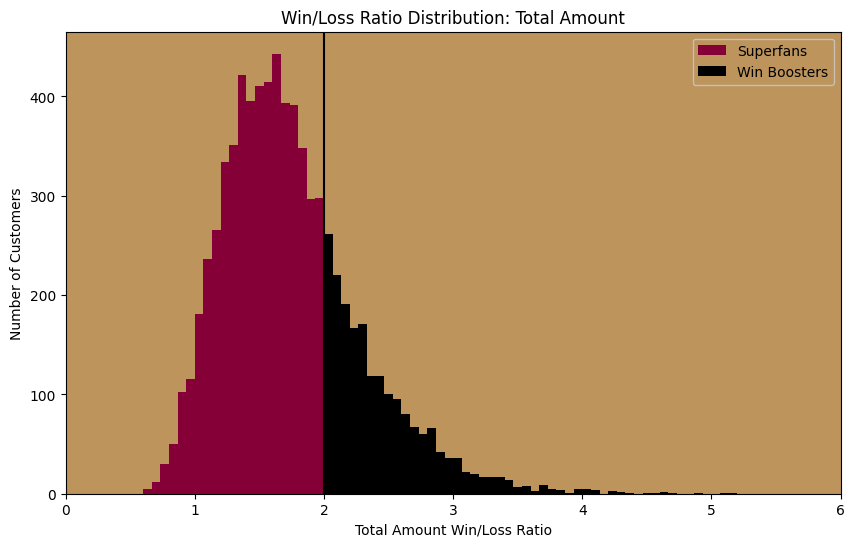

In [ ]:
winsplit = df[df['cluster'] == 0].groupby(['customer_id', 'win'])['total_amount'].sum().unstack()
winsplit.rename(columns={0: 'Loss', 1: 'Win'}, inplace=True)
winsplit['ratio'] = winsplit['Win'] / winsplit['Loss']
fig,ax = plt.subplots(figsize=(10,6))
ax.hist(winsplit['ratio'][winsplit['ratio'] < 2], bins=90, color=C[0], range=(0, 6), label='Superfans')
ax.hist(winsplit['ratio'][winsplit['ratio'] >= 2], bins=90, color=C[1], range=(0, 6), label='Win Boosters')

# Add the vertical line
plt.axvline(2, color='k')
plt.xlim((0, 6))
plt.legend()
plt.title('Win/Loss Ratio Distribution: Total Amount')
plt.xlabel('Total Amount Win/Loss Ratio')
plt.ylabel('Number of Customers')
plt.show()

In [ ]:
winsplit[winsplit['ratio'] >= 2].shape

(2004, 3)

# Prelim

In [17]:
df = df_transactions()

In [18]:
def group_by_item(df, ax=None):
    item_totals = df.groupby('item').agg({
        'total_amount': 'sum',
        'category': 'first'
    }).sort_values(by='total_amount', ascending=False)
    item_cat = item_totals['category']
    item_totals = item_totals['total_amount'] / 1_000_000

    # Plot the results
    if ax is None:
        fig, ax = plt.subplots()
    bars = ax.bar(range(len(item_totals)), item_totals.values)

    ax.set_title('Total Amount Spent by Item')
    ax.set_xlabel('Item')
    ax.set_ylabel('Total Amount (USD Millions)')

    # Rotate x-axis labels for better readability
    ax.set_xticks(range(len(item_totals)))
    ax.set_xticklabels(item_totals.index, rotation=90)

    # Set bar colors and add value labels
    for bar_ndx, bar in enumerate(bars):
        height = bar.get_height()
        bar.set_facecolor(C[1] if item_cat.iloc[bar_ndx] == 'fnb' else C[0])

    # Manually create handles for the legend
    from matplotlib.patches import Patch
    legend_handles = [Patch(color=C[1], label='Food and Beverage'),
                      Patch(color=C[0], label='Retail')]
    ax.legend(handles=legend_handles)

    return ax

def group_by_payment_method(df, ax=None):
    payment_totals = df.groupby(['payment_method', 'category'])['total_amount'].sum().unstack().fillna(0)
    payment_totals['sum'] = payment_totals.sum(axis=1)
    payment_totals = payment_totals / 1_000_000
    payment_totals = payment_totals.drop(columns=['sum'])

    # Payment Method Visualization
    if ax is None:
        fig, ax = plt.subplots()
    bars1 = payment_totals.plot(kind='bar', stacked=True, ax=ax, color=[C[1], C[0]])
    ax.set_title('Total Amount Spent by Payment Method')
    ax.set_xlabel('Payment Method')
    ax.set_ylabel('Total Amount (USD Millions)')
    ax.legend(['Food and Beverage', 'Retail', ])
    # ax.tick_params(axis='x', rotation=45)

    for c in bars1.containers:
        bars1.bar_label(c, fmt='%.2f', label_type='center', color='white', path_effects=[pe.withStroke(linewidth=3, foreground='k')])
    return ax

def group_by_location(df, ax=None):
    location_totals = df.groupby(['location', 'category'])['total_amount'].sum().unstack().fillna(0)
    location_totals['sum'] = location_totals.sum(axis=1)
    location_totals = location_totals.sort_values(by='sum', ascending=False) / 1_000_000
    location_totals = location_totals.drop(columns=['sum'])

    # Location Visualization
    if ax is None:
        fig, ax = plt.subplots()
    bars2 = location_totals.plot(kind='bar', stacked=True, ax=ax, color=[C[1], C[0]])
    ax.set_title('Total Amount Spent by Location')
    ax.set_xlabel('Location')
    ax.set_ylabel('Total Amount (USD Millions)')
    ax.legend(['Food and Beverage', 'Retail', ])
    # ax.tick_params(axis='x', rotation=45)

    for c in bars2.containers:
        # Only label bars with a height greater than 0
        labels = [f'{v:.2f}' if v > 0 else '' for v in c.datavalues]
        bars2.bar_label(c, labels=labels, label_type='center', rotation=90, color='white', path_effects=[pe.withStroke(linewidth=3, foreground='k')])
    return ax


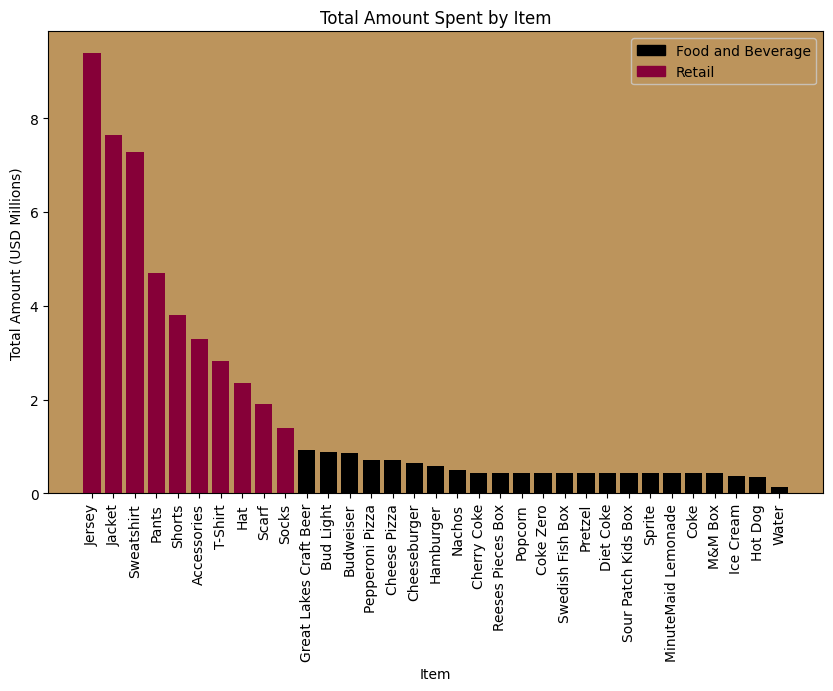

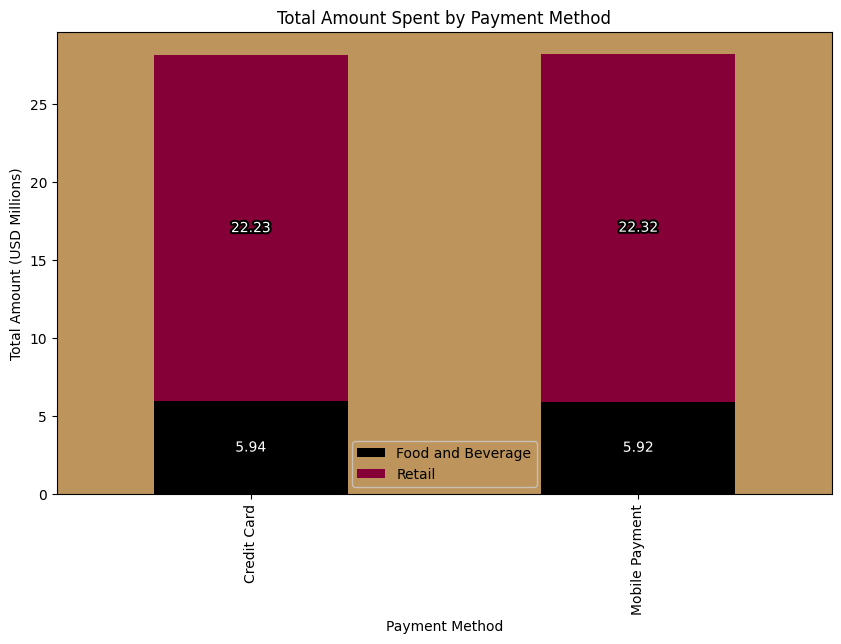

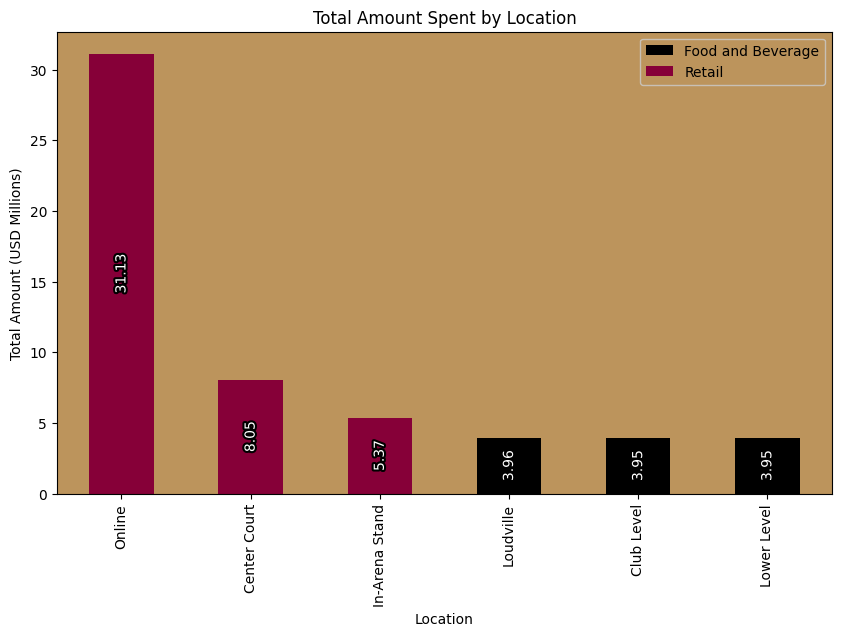

In [19]:
# fig, ax = plt.subplots(1,3,figsize=(20,5))
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
group_by_item(df, ax=ax)
fig, ax = plt.subplots(1, 1, figsize=(10,6))
group_by_payment_method(df, ax=ax)
fig, ax = plt.subplots(1, 1, figsize=(10,6))
group_by_location(df, ax=ax)
plt.show()